## Demo ilustrating problem setup from Python

We will ilustrate the steps on a simple truss structure.

First we need to install OOFEM wasm wheel for Pyodide and import needed modules.

In [1]:
# Preliminary step to install OOFEM wasm wheel for Pyodide 
%pip install https://www.oofem.org/download/oofem-2.6.0.dev2-cp312-cp312-pyodide_2024_0_wasm32.whl

In [2]:
# Import python modules needed for the example 
import oofem as oofempy
import oofem.util 
import numpy
import matplotlib

Matplotlib is building the font cache; this may take a moment.


### Set up the problem

This includes the following steps
* Set up the problem (staticStructural), create an empty domain
* Create domain components
  * time functions
  * boundary conditions (in our case prescribed (fixed) displacement and nodal load)
  * nodes
  * material models and cross sections
  * elements
* Add these components to domain


In [6]:
problem = oofempy.staticStructural(nSteps=1, outFile="test2.out") # engngModel
domain = oofempy.domain(1, 1, problem, oofempy.domainType._2dTrussMode, tstep_all=True, dofman_all=True, element_all=True) # domain aka mesh
problem.setDomain(1, domain, True) # associate domain to the problem
# load time function
ltf1 = oofempy.peakFunction(1, domain, t=1, f_t=1)
ltfs = (ltf1, )
# boundary conditions
# loadTimeFunction parameter can be specified as int value or as LoadTimeFunction itself (valid for all objects with giveNumber() method)
bc1   = oofempy.boundaryCondition(    1, domain, loadTimeFunction=1,    prescribedValue=0.0)
nLoad = oofempy.nodalLoad(            2, domain, loadTimeFunction=1,    components=(0.,-20.))
bcs = (bc1, nLoad)
# nodes
# if one value is passed as parameter where oofem expects array of values, it must be passed as tuple or list (see load in n4)
n1 = oofempy.node(1, domain, coords=(0., 0., 0. ), bc=(bc1,bc1))
n2 = oofempy.node(2, domain, coords=(4., 0., 0. ), bc=(0,0), load = (nLoad,))
n3 = oofempy.node(3, domain, coords=(8., 0., 0. ), bc=(0,bc1))
n4 = oofempy.node(4, domain, coords=(2., 0., -3. ))
n5 = oofempy.node(5, domain, coords=(6., 0., -3. ))
nodes = (n1, n2, n3, n4, n5)
# material and cross section
mat = oofempy.isoLE(1, domain, d=1., E=210.e6, n=0.2, tAlpha=1.2e-5)
cs  = oofempy.simpleCS(1, domain, area=0.00016)
# elements
e1 = oofempy.truss2d(1, domain, nodes=(n1,n2),  mat=1,   crossSect=1)
e2 = oofempy.truss2d(2, domain, nodes=(n2,n3),  mat=1,   crossSect=1)
e3 = oofempy.truss2d(3, domain, nodes=(n1,n4),  mat=1,   crossSect=1)
e4 = oofempy.truss2d(4, domain, nodes=(n4,n2),  mat=1,   crossSect=1)
e5 = oofempy.truss2d(5, domain, nodes=(n2,n5),  mat=1,   crossSect=1)
e6 = oofempy.truss2d(6, domain, nodes=(n5,n3),  mat=1,   crossSect=1)
e7 = oofempy.truss2d(7, domain, nodes=(n4,n5),  mat=1,   crossSect=1)
elems = (e1, e2, e3, e4, e5, e6, e7)
# add eveything to domain
oofem.util.setupDomain (domain, nodes, elems, (cs,), (mat,), bcs, (), ltfs, ())

Next we initialize problem and solve it 

In [7]:
problem.checkProblemConsistency()
problem.init()
problem.postInitialize()
problem.setRenumberFlag()
problem.solveYourself()

The following section illustrates postprocessing. 

* We will plot normal forces on deformed configuration.
* Our case is little different than a standard continnuum problem, as 
the internal forces could not be represented as continuuum field.
* We evaluate normal forces on each element and pass it to the utility plotting function.

<oofem.oofempy.TimeStep object at 0x1a76138> <oofem.oofempy.Field object at 0x1d6fe80>


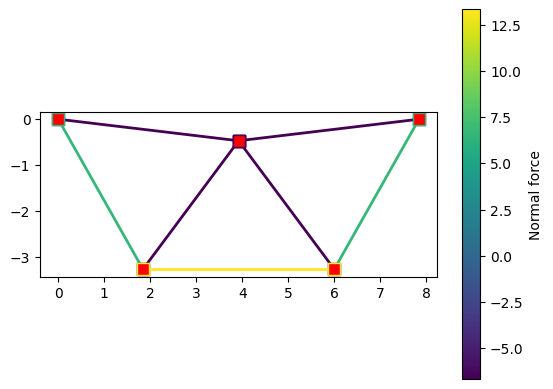

In [8]:
d=problem.giveDomain(1)
tstep = problem.giveCurrentStep()
    

field = problem.giveField(oofempy.FieldType.FT_Displacements, tstep)
print(tstep, field)

evals = []
for i in range(1, d.giveNumberOfElements()+1):
    e=d.giveElement(i)
    if (e.giveGeometryType() == oofempy.Element_Geometry_Type.EGT_line_1):
        val = oofempy.FloatArray()
        e.giveCharacteristicVector(val, oofempy.CharType.InternalForcesVector, oofempy.ValueModeType.VM_Total, tstep)
        evals.append(-val[0])

oofem.util.plot1Dmesh(d, tstep, xind=0, yind=2, warpField=field, warpScale=1.e2, evals=evals, label="Normal force").show()